**Taking only the required libraries for the visualization**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from numpy import *
import numpy as np
import seaborn as sns
import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
from xgboost import plot_importance
# from matplotlib import pyplot
%matplotlib inline
from tqdm import tqdm_notebook
import random
import math
import pandas_profiling
import warnings
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import AdaBoostClassifier
# from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
import sklearn
warnings.filterwarnings('ignore')

In [680]:
print("scikit-learn version: {}". format(sklearn.__version__))

scikit-learn version: 0.19.1


In [527]:
init_notebook_mode(connected=True)

## Reading Provided the dataset

some NA values can't just 'NA' there could be a white space or a question mark

na_values=[" ",".","NA","?","-",""] so using in this way we can specify possible list of NA values

In [528]:
train_data = pd.read_csv('Train.csv',na_values=[" ",".","NA","?","-",""])
train_vehicle = pd.read_csv('Train_Vehicletravellingdata.csv',na_values=[" ",".","NA","?","-",""])
train_weather = pd.read_csv('Train_WeatherData.csv',na_values=[" ",".","NA","?","-",""])

In [529]:
Class1_filter = train_data[train_data['DrivingStyle']==1]

In [530]:
Class2_filter = train_data[train_data['DrivingStyle']==2]

In [531]:
Class2_filter = Class2_filter[0:2774]

In [532]:
Class3_filter = train_data[train_data['DrivingStyle']==3]

In [533]:
Class3_filter = Class3_filter[0:2774]

In [534]:
del train_data

In [535]:
print(Class1_filter.shape)
print(Class2_filter.shape)
print(Class3_filter.shape)

(2774, 5)
(2774, 5)
(2774, 5)


In [536]:
class_list = [Class1_filter,Class2_filter,Class3_filter]

In [537]:
train_data = pd.concat(class_list,axis=0)

First we will take The Train.csv file and do the basic observation of the data like info and shape as well as count of null values

We will also rename the columns for easy interpretation

**Let's take one dataset at a time: Train data**

ID              :"ID"
V2              :"vehicle_length_cm"
V5              :"vehicle_weight_kg"
V6              :"number_of_axles"
DrivingStyle    :"DrivingStyle"(Target)

In [538]:
train_data['DrivingStyle'].value_counts()

3    2774
2    2774
1    2774
Name: DrivingStyle, dtype: int64

In [539]:
print(train_data.shape)
train_data.isnull().sum()

(8322, 5)


ID              0
V2              0
V5              0
V6              0
DrivingStyle    0
dtype: int64

In [540]:
train_data.columns = ["ID","vehicle_length_cm","vehicle_weight_kg","number_of_axles","DrivingStyle"]

In [541]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8322 entries, 8 to 9406
Data columns (total 5 columns):
ID                   8322 non-null object
vehicle_length_cm    8322 non-null int64
vehicle_weight_kg    8322 non-null int64
number_of_axles      8322 non-null int64
DrivingStyle         8322 non-null int64
dtypes: int64(4), object(1)
memory usage: 390.1+ KB


from above output it is evident that there is no null value

**Let's take the Second dataset: Vehicle data**

We will perform the same operations as above

In [542]:
train_vehicle.columns = ["ID","trip_datetime","lane_no","vehicle_speed","pvehicle_id","pvehicle_speed_kph","pvehicle_weight_kg","pvehicle_length_cm","pvehicle_timegap","weather_road_cond"]

Column pvehicle_timegap has 2455 null values

In [543]:
# checking null values in train_vehicle
print(train_vehicle.shape)
train_vehicle.isnull().sum()

(162566, 10)


ID                       0
trip_datetime            0
lane_no                  0
vehicle_speed            0
pvehicle_id              0
pvehicle_speed_kph       0
pvehicle_weight_kg       0
pvehicle_length_cm       0
pvehicle_timegap      2455
weather_road_cond        0
dtype: int64

for pvehicle_timegap we will do a mean imputation. But the value generated by mean calculation will be in floating point, hence converting the mean value to the closest value by converting it to integer datatype

In [544]:
train_vehicle['pvehicle_timegap'] = train_vehicle['pvehicle_timegap'].fillna(train_vehicle['pvehicle_timegap'].mean())

In [545]:
train_vehicle['pvehicle_timegap'] = train_vehicle['pvehicle_timegap'].astype('int64')

We will also change the datatype of trip_datetime to datetime64 so that we can use that in future as and when required

In [546]:
train_vehicle['trip_datetime'] = train_vehicle['trip_datetime'].astype('datetime64')

In [547]:
train_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162566 entries, 0 to 162565
Data columns (total 10 columns):
ID                    162566 non-null object
trip_datetime         162566 non-null datetime64[ns]
lane_no               162566 non-null int64
vehicle_speed         162566 non-null int64
pvehicle_id           162566 non-null int64
pvehicle_speed_kph    162566 non-null int64
pvehicle_weight_kg    162566 non-null int64
pvehicle_length_cm    162566 non-null int64
pvehicle_timegap      162566 non-null int64
weather_road_cond     162566 non-null object
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 12.4+ MB


**Let's take the Second dataset: Weather data**

We will perform the same operations here as well

In [548]:
train_weather.columns = ["ID",'trip_datetime','air_temp','prep_type','prep_intensity','realtive_humidity','wind_direction','wind_speed_ms','daylight_cond']

In [549]:
train_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162566 entries, 0 to 162565
Data columns (total 9 columns):
ID                   162566 non-null object
trip_datetime        162566 non-null object
air_temp             160509 non-null float64
prep_type            162566 non-null object
prep_intensity       160292 non-null object
realtive_humidity    160461 non-null float64
wind_direction       160452 non-null float64
wind_speed_ms        160102 non-null float64
daylight_cond        162566 non-null object
dtypes: float64(4), object(5)
memory usage: 11.2+ MB


In [550]:
# checking null values in train_weather
print(train_weather.shape)
train_weather.isnull().sum()

(162566, 9)


ID                      0
trip_datetime           0
air_temp             2057
prep_type               0
prep_intensity       2274
realtive_humidity    2105
wind_direction       2114
wind_speed_ms        2464
daylight_cond           0
dtype: int64

Mode imputation for prep_intensity and for the rest of the null value columns we will do mean Imputation and try to bring them to their nearest value by using ceil and floor functions

In [551]:
train_weather['air_temp'] = train_weather['air_temp'].fillna(math.ceil(train_weather['air_temp'].mean()))  #ceil
train_weather['realtive_humidity'] = train_weather['realtive_humidity'].fillna(math.ceil(train_weather['realtive_humidity'].mean()))
train_weather['wind_direction'] = train_weather['wind_direction'].fillna(180) #ceil
train_weather['wind_speed_ms'] = train_weather['wind_speed_ms'].fillna(math.floor(train_weather['wind_speed_ms'].mean()))

In [552]:
train_weather['prep_intensity'] = train_weather['prep_intensity'].astype('category')

In [553]:
# train_weather['prep_intensity'].mode()

In [554]:
train_weather['prep_intensity'] = train_weather['prep_intensity'].fillna(train_weather['prep_intensity'].mode()[0])

In [555]:
train_weather.isnull().sum()

ID                   0
trip_datetime        0
air_temp             0
prep_type            0
prep_intensity       0
realtive_humidity    0
wind_direction       0
wind_speed_ms        0
daylight_cond        0
dtype: int64

In [556]:
train_weather['trip_datetime'] = train_weather['trip_datetime'].astype('datetime64')

**The basic preprocessing finishes here now we will join all the dataset using 'Inner' Join**

The Inner join between the train data and vehicle data will be done on the basis of 'ID' column

The Inner join between the joined data and weather data will be done on the basis of 'ID' and 'trip_datetime' column

In [557]:
data = pd.merge(train_data,train_vehicle,on='ID',how='inner')
print(data.shape)
data = pd.merge(data,train_weather,on=['ID','trip_datetime'],how='inner')
print(data.shape)

(103155, 14)
(103155, 21)


In [558]:
# for efficient memory usage
del train_data
del train_vehicle
del train_weather

converting all the object data type columns to categories

In [559]:
for column in data.columns:
    if data[column].dtypes == 'object':
        data[column] = data[column].astype('category')

checking the summary statistics for all the columns

In [560]:
data.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ID,103155,8322,DR_19735,91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_length_cm,103155,NaN,NaN,NaN,NaN,NaN,891.835,513.181,155,551,579,1301,2337
vehicle_weight_kg,103155,NaN,NaN,NaN,NaN,NaN,6573.14,8533.34,44,1643,2083,9486,57230
number_of_axles,103155,NaN,NaN,NaN,NaN,NaN,2.92816,1.52322,2,2,2,4,9
DrivingStyle,103155,NaN,NaN,NaN,NaN,NaN,2.09628,0.769772,1,1,2,3,3
trip_datetime,103155,103139,2012-05-23 03:09:18,2,2012-03-21 09:14:55,2013-04-30 16:57:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lane_no,103155,NaN,NaN,NaN,NaN,NaN,1.49588,0.499985,1,1,1,2,2
vehicle_speed,103155,NaN,NaN,NaN,NaN,NaN,83.4984,9.56393,8,78,83,88,161
pvehicle_id,103155,NaN,NaN,NaN,NaN,NaN,321166,249248,20,111074,164566,585536,794435
pvehicle_speed_kph,103155,NaN,NaN,NaN,NaN,NaN,83.4891,9.55539,0,78,83,88,161


Checking the corealtion of all the columns with each other

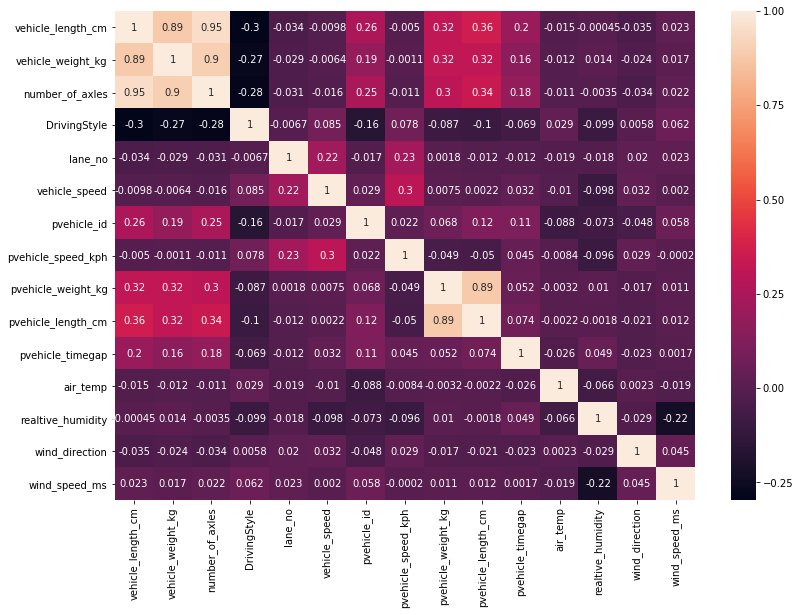

In [561]:
f, ax = plt.subplots(figsize=(13,9))
sns.heatmap(data.corr(),annot=True)

so from above graph it is evident that features have less correlation with each other, which means each feature has lot of variance. Further check the values between vehicle_length_cm vs pvehicle_length_cm

we'll try to further disect down the time_gap columns into following: Day, Month, Year, Hour, Minute, Second

In [562]:
data['trip_date'] = data['trip_datetime'].dt.date
data['trip_date_day'] = data['trip_datetime'].dt.day
data['trip_month'] = data['trip_datetime'].dt.month
data['trip_year'] = data['trip_datetime'].dt.year
data['trip_time'] = data['trip_datetime'].dt.time
data['trip_hour'] = data['trip_datetime'].dt.hour
data['trip_minute'] = data['trip_datetime'].dt.minute
data['trip_sec'] = data['trip_datetime'].dt.second

Calculating the speed differnce between the current vehicle and the preceeding vehicle

In [563]:
data['speed_difference'] = data['vehicle_speed'] - data['pvehicle_speed_kph']

since we have the speed and timegap between the current vehicle and preceeding vehicle we will make of this formula to calculate the distance between the current and the preceeding vehicle

                                               speed=distance/time

In [564]:
data['distance'] = (data['pvehicle_speed_kph']/3.6)*data['pvehicle_timegap']

In [565]:
data['distance'] = data['distance'].astype('int64')

In [566]:
# calculating the bin size
bins = list(range(0,data['distance'].max()+10,18613))

In [567]:
labels = ['Low','Medium','High']
data['binned_distance'] = pd.cut(data['distance'], bins=bins, labels=labels)
data['binned_distance'].value_counts()

Low       101682
Medium      1337
High         135
Name: binned_distance, dtype: int64

In [568]:
data.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'DrivingStyle', 'trip_datetime', 'lane_no', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'weather_road_cond',
       'air_temp', 'prep_type', 'prep_intensity', 'realtive_humidity',
       'wind_direction', 'wind_speed_ms', 'daylight_cond', 'trip_date',
       'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour',
       'trip_minute', 'trip_sec', 'speed_difference', 'distance',
       'binned_distance'],
      dtype='object')

PCA Clustering
1. Decision Tree
2. Random Forest
3. Adaboost
4. XGBoost
5. Catboost
6. LightGBM

Then SMOTING
-Then try w1 method

**Plot yearly basis graph**

In [569]:
data.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'DrivingStyle', 'trip_datetime', 'lane_no', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'weather_road_cond',
       'air_temp', 'prep_type', 'prep_intensity', 'realtive_humidity',
       'wind_direction', 'wind_speed_ms', 'daylight_cond', 'trip_date',
       'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour',
       'trip_minute', 'trip_sec', 'speed_difference', 'distance',
       'binned_distance'],
      dtype='object')

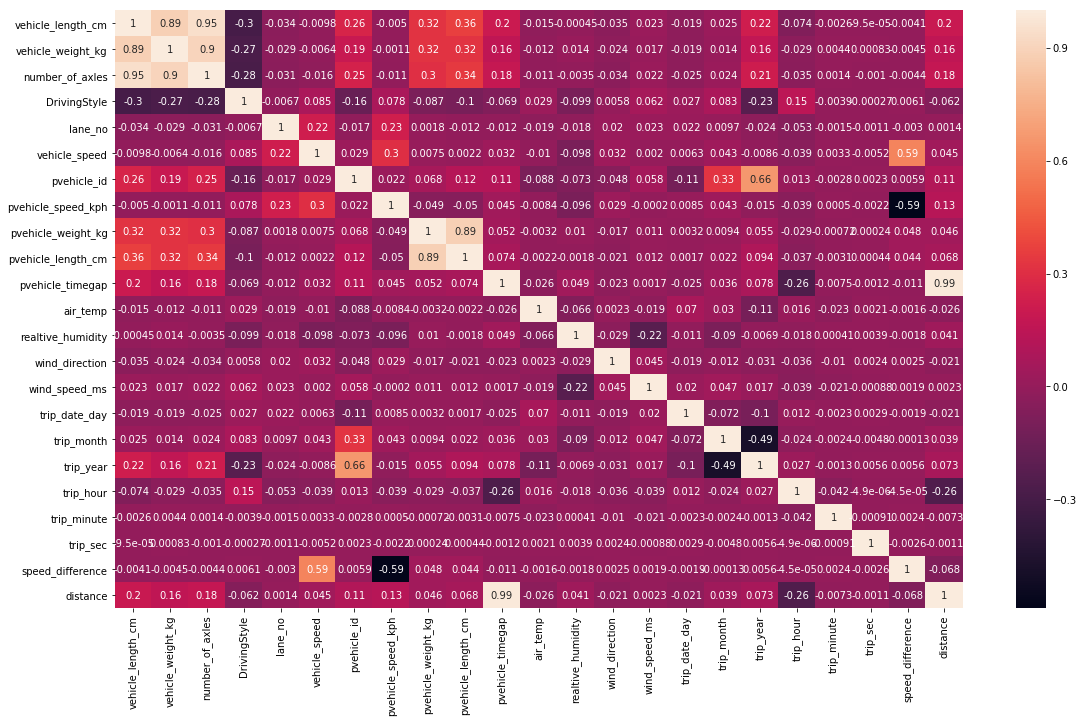

In [570]:
f, ax = plt.subplots(figsize=(19,11))
sns.heatmap(data.corr(),annot=True)

In [571]:
categorical_columns = ['number_of_axles','DrivingStyle','lane_no','weather_road_cond','prep_type','prep_intensity','daylight_cond']

In [572]:
copy_data = data.copy()

In [573]:
copy_data[categorical_columns] = copy_data[categorical_columns].astype('category')

In [574]:
data.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'DrivingStyle', 'trip_datetime', 'lane_no', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'weather_road_cond',
       'air_temp', 'prep_type', 'prep_intensity', 'realtive_humidity',
       'wind_direction', 'wind_speed_ms', 'daylight_cond', 'trip_date',
       'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour',
       'trip_minute', 'trip_sec', 'speed_difference', 'distance',
       'binned_distance'],
      dtype='object')

In [575]:
for i in categorical_columns:
    print("\n")
    print(i," ",copy_data[i].unique())



number_of_axles   [3, 6, 2, 5, 4, 7, 9, 8]
Categories (8, int64): [3, 6, 2, 5, 4, 7, 9, 8]


DrivingStyle   [1, 2, 3]
Categories (3, int64): [1, 2, 3]


lane_no   [2, 1]
Categories (2, int64): [2, 1]


weather_road_cond   [Wet, Dry, Snow covered, Visible tracks]
Categories (4, object): [Wet, Dry, Snow covered, Visible tracks]


prep_type   [clear, rain, snow]
Categories (3, object): [clear, rain, snow]


prep_intensity   [None, Low, Moderate, High]
Categories (4, object): [None, Low, Moderate, High]


daylight_cond   [daylight, night, twilight]
Categories (3, object): [daylight, night, twilight]


In [576]:
copy_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103155 entries, 0 to 103154
Data columns (total 32 columns):
ID                    103155 non-null category
vehicle_length_cm     103155 non-null int64
vehicle_weight_kg     103155 non-null int64
number_of_axles       103155 non-null category
DrivingStyle          103155 non-null category
trip_datetime         103155 non-null datetime64[ns]
lane_no               103155 non-null category
vehicle_speed         103155 non-null int64
pvehicle_id           103155 non-null int64
pvehicle_speed_kph    103155 non-null int64
pvehicle_weight_kg    103155 non-null int64
pvehicle_length_cm    103155 non-null int64
pvehicle_timegap      103155 non-null int64
weather_road_cond     103155 non-null category
air_temp              103155 non-null float64
prep_type             103155 non-null category
prep_intensity        103155 non-null category
realtive_humidity     103155 non-null float64
wind_direction        103155 non-null float64
wind_speed_ms    

In [577]:
id_col= copy_data['ID']
pvehicle_id = copy_data['pvehicle_id']

In [578]:
copy_data.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'DrivingStyle', 'trip_datetime', 'lane_no', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'weather_road_cond',
       'air_temp', 'prep_type', 'prep_intensity', 'realtive_humidity',
       'wind_direction', 'wind_speed_ms', 'daylight_cond', 'trip_date',
       'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour',
       'trip_minute', 'trip_sec', 'speed_difference', 'distance',
       'binned_distance'],
      dtype='object')

In [579]:
dropping_columns = ['trip_date', 'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour', 'trip_minute', 'trip_sec', 'ID', 'trip_datetime','speed_difference', 'distance', 'binned_distance','pvehicle_id']

In [580]:
copy_data.drop(dropping_columns,axis=1,inplace=True)

In [581]:
DrivingStyle_df = copy_data['DrivingStyle']

In [582]:
dummified_df =pd.get_dummies(copy_data[categorical_columns])

In [583]:
copy_data.drop(categorical_columns,axis=1,inplace=True)

In [584]:
dummified_df.drop(['DrivingStyle_1', 'DrivingStyle_2', 'DrivingStyle_3'],axis=1,inplace=True)

In [585]:
scaler = StandardScaler()
scaler.fit(copy_data)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [586]:
scale_df = data[['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed', 'pvehicle_speed_kph', 'pvehicle_weight_kg', 'pvehicle_length_cm', 'pvehicle_timegap', 'air_temp', 'realtive_humidity', 'wind_direction', 'wind_speed_ms']]

In [587]:
scale_df.columns

Index(['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed',
       'pvehicle_speed_kph', 'pvehicle_weight_kg', 'pvehicle_length_cm',
       'pvehicle_timegap', 'air_temp', 'realtive_humidity', 'wind_direction',
       'wind_speed_ms'],
      dtype='object')

In [588]:
# pca_df[['air_temp','realtive_humidity','wind_direction','wind_speed_ms','trip_hour']] = pca_df[['air_temp','realtive_humidity','wind_direction','wind_speed_ms','trip_hour']].astype('int64')
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(scale_df)

# Apply transform to both the training set and the test set.
scaled_df = scaler.transform(scale_df)
# test_img = scaler.transform(test_img)

In [589]:
scaled_df = pd.DataFrame(scaled_df,columns=['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed', 'pvehicle_speed_kph', 'pvehicle_weight_kg','pvehicle_length_cm', 'pvehicle_timegap', 'air_temp','realtive_humidity', 'wind_direction', 'wind_speed_ms'])

In [590]:
df_list  = [scaled_df,dummified_df]
copy_data = pd.concat(df_list,axis='columns')

In [591]:
copy_data.shape

(103155, 35)

In [592]:
copy_data.columns

Index(['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed',
       'pvehicle_speed_kph', 'pvehicle_weight_kg', 'pvehicle_length_cm',
       'pvehicle_timegap', 'air_temp', 'realtive_humidity', 'wind_direction',
       'wind_speed_ms', 'number_of_axles_2', 'number_of_axles_3',
       'number_of_axles_4', 'number_of_axles_5', 'number_of_axles_6',
       'number_of_axles_7', 'number_of_axles_8', 'number_of_axles_9',
       'lane_no_1', 'lane_no_2', 'weather_road_cond_Dry',
       'weather_road_cond_Snow covered', 'weather_road_cond_Visible tracks',
       'weather_road_cond_Wet', 'prep_type_clear', 'prep_type_rain',
       'prep_type_snow', 'prep_intensity_High', 'prep_intensity_Low',
       'prep_intensity_Moderate', 'prep_intensity_None',
       'daylight_cond_daylight', 'daylight_cond_night',
       'daylight_cond_twilight'],
      dtype='object')

In [593]:
# DrivingStyle_df = copy_data[['DrivingStyle_1', 'DrivingStyle_2', 'DrivingStyle_3']]

In [594]:
# copy_data.drop(['DrivingStyle_1', 'DrivingStyle_2', 'DrivingStyle_3'],axis=1,inplace=True)

In [595]:
data.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'DrivingStyle', 'trip_datetime', 'lane_no', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'weather_road_cond',
       'air_temp', 'prep_type', 'prep_intensity', 'realtive_humidity',
       'wind_direction', 'wind_speed_ms', 'daylight_cond', 'trip_date',
       'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour',
       'trip_minute', 'trip_sec', 'speed_difference', 'distance',
       'binned_distance'],
      dtype='object')

In [596]:
# pca_df = data[['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed', 'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg', 'pvehicle_length_cm', 'pvehicle_timegap', 'air_temp', 'realtive_humidity', 'wind_direction', 'wind_speed_ms', 'trip_date_day', 'trip_month', 'trip_year', 'trip_hour', 'trip_minute', 'trip_sec', 'speed_difference', 'distance']]

In [597]:
# len(pca_df.columns)

In [598]:
# pca = PCA(.99)

In [599]:
# pca.fit(pcadf_scaled)

In [600]:
# pca.n_components_

In [601]:
# pcadf_scaled = pd.DataFrame(pcadf_scaled)

In [602]:
# pcadf_scaled.head()

In [657]:
train_split_X, val_split_X, train_split_Y, val_split_Y = train_test_split(copy_data, DrivingStyle_df, test_size=0.40, random_state=42,stratify=DrivingStyle_df)

In [658]:
print(train_split_X.shape)
print(val_split_X.shape)
print(train_split_Y.shape)
print(val_split_Y.shape)

(61893, 35)
(41262, 35)
(61893,)
(41262,)


In [605]:
# list_of_all_columns = train_split_X.columns

In [606]:
def decision_tree():
    print("-"*30,"Decision_Tree")
    # Creating an object for decision Trees
    clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

    #Using the object created for decision Trees to fit on train data
    clf.fit(train_split_X, train_split_Y)
    
    feat_importance(clf.feature_importances_,"Decision Tree")

    #Using the object created for decision Trees to predict on validation data
    y_pred_dt = clf.predict(val_split_X)

    #Using the object created for decision Trees to predict on test data
#     test_y_pred_dt = clf.predict(test_data_cluster_4)

    #Calculating the accuracy of train data
    acc_dt_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
    print ('train_accuracy_dt: ' +' '+str(acc_dt_train) + ' percent')

    #Calculating the accuracy of validation data
    acc_dt_validation = accuracy_score(val_split_Y, y_pred_dt)
    print('validation_accuracy_dt: '+str(round((acc_dt_validation)*100,2)) + 'percent')
    print(classification_report(val_split_Y, y_pred_dt))
#     dt_precision,dt_recall,dt_fscore,dt_support = precision_recall_fscore_support(val_split_Y, y_pred_dt, average='micro',labels=[1])
#     print("Recall: ",dt_recall)
#     print("Precision: ",dt_precision)
# nestimator,criterion,spliiter,classweight,min_sample_split

In [607]:
def feat_importance(best_features,algo):
    col = train_split_X.columns
    #modelname.feature_importance_
    y = best_features
    #plot
    fig, ax = plt.subplots() 
    width = 0.4 # the width of the bars 
    ind = np.arange(len(y)) # the x locations for the groups
    ax.barh(ind, y, width, color="green")
    ax.set_yticks(ind+width/10)
    ax.set_yticklabels(col, minor=False)
    plt.title('Feature importance in '+algo)
    plt.xlabel('Relative importance')
    plt.ylabel('feature') 
    plt.figure(figsize=(5,7))
    fig.set_size_inches(6.5, 9.5, forward=True)

In [608]:
def random_forest():
    print("-"*30,"Random Forest")
    # Creating an object for Random Forest
    clf = RandomForestClassifier(n_estimators= 1000, min_samples_split= 2, min_samples_leaf= 1, max_features= 'auto', max_depth= 50, bootstrap= False,n_jobs=-1)

    #Using the object created for Random Forest to fit on train data
    clf.fit(train_split_X, train_split_Y)

    #checking the feature importance
    feat_importance(clf.feature_importances_,"Random Forest")
    
    #Using the object created for Random Forest to predict on validation data
    y_pred_rf = clf.predict(val_split_X)

    #Using the object created for Random Forest to predict on test data
#     test_y_pred_rf = clf.predict(test_data_cluster_4)

    #Calculating the accuracy of train data
    acc_rf_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
    print ('train_accuracy_rf: ' +' '+str(acc_rf_train) + ' percent')

    #Calculating the accuracy of validation data
    acc_rf_validation = accuracy_score(val_split_Y, y_pred_rf)
    print('validation_accuracy_rf: '+str(round((acc_rf_validation)*100,2)) + 'percent')
    print(classification_report(val_split_Y, y_pred_rf))
#     rf_precision,rf_recall,rf_fscore,rf_support = precision_recall_fscore_support(val_split_Y, y_pred_rf, average='micro',labels=[1])
#     print("Recall: ",rf_recall)
#     print("Precision: ",rf_precision)

In [609]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap
#               }
# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# # Fit the random search model
# rf_random.fit(val_split_X, val_split_Y)
# print("gsearch2b.best_params_",rf_random.best_params_)
# y_pred_rf = rf_random.predict(val_split_Y)
# print(classification_report(val_split_Y, y_pred_rf))


In [674]:
def adaboost():
    print("-"*30,"Adaboost")
    # Creating an object for Adaboost
    clf = AdaBoostClassifier()

    #Using the object created for Adaboost to fit on train data
    clf.fit(train_split_X, train_split_Y)

    #Using the object created for Adaboost to predict on validation data
    y_pred_adaboost = clf.predict(val_split_X)
    feat_importance(clf.feature_importances_,"ADABoost")

    #Using the object created for Adaboost to predict on test data
#     test_y_pred_adaboost = clf.predict(test_data_cluster_4)

    #Calculating the accuracy of train data
    acc_adaboost_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
    print ('train_accuracy_adaboost: ' +' '+str(acc_adaboost_train) + ' percent')

    #Calculating the accuracy of validation data
    acc_adaboost_validation = accuracy_score(val_split_Y, y_pred_adaboost)
    print('validation_accuracy_adaboost: '+str(round((acc_adaboost_validation)*100,2)) + 'percent')
    print(classification_report(val_split_Y, y_pred_adaboost))
#     print("Recall: ",ada_recall)
#     print("Precision: ",ada_precision)

In [681]:
def sgd():
    print("-"*30,"SGD")
    # Creating an object for Stocahstic gradient decsent
    clf = SGDClassifier(max_iter=5, tol=None,n_jobs=-1,)

    #Using the object created for Stocahstic gradient decsent to fit on train data
    clf.fit(train_split_X, train_split_Y)

    #Using the object created for Stocahstic gradient decsent to predict on validation data
    y_pred_sgd = clf.predict(val_split_X)
#     feat_importance(clf.feature_importances_,"SGBoost")

    #Using the object created for Stocahstic gradient decsent to predict on test data
#     test_y_pred_sgd = clf.predict(test_data_cluster_4)

    #Calculating the accuracy of train data
    acc_sgd_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
    print ('train_accuracy' +' '+str(acc_sgd_train) + ' percent')

    #Calculating the accuracy of validation data
    acc_sgd_validation = accuracy_score(val_split_Y, y_pred_sgd)
    print('validation_accuracy '+str(round((acc_sgd_validation)*100,2)) + 'percent')
    print(classification_report(val_split_Y, y_pred_sgd))

#     print(precision_recall_fscore_support(val_split_Y, acc_sgd_validation))
#     print("Recall: ",sgd_recall)
#     print("Precision: ",sgd_precision)

In [676]:
def xgboost():
    print("-"*30,"XGBoost")
    # Creating an object for Stocahstic gradient decsent
    clf = XGBClassifier(max_iter=5, tol=None,n_jobs=-1)

    #Using the object created for Stocahstic gradient decsent to fit on train data
    clf.fit(train_split_X, train_split_Y,)

    #Using the object created for Stocahstic gradient decsent to predict on validation data
    y_pred_xgb = clf.predict(val_split_X)
    feat_importance(clf.feature_importances_,"XGBoost")
#     plt.bar(range(len(clf.feature_importances_)), clf.feature_importances_)
#     pyplot.show()
#     plot_importance(clf)
#     plt.show()

    #Using the object created for Stocahstic gradient decsent to predict on test data
#     test_y_pred_sgd = clf.predict(test_data_cluster_4)

    #Calculating the accuracy of train data
    acc_xgb_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
    print ('train_accuracy' +' '+str(acc_xgb_train) + ' percent')

    #Calculating the accuracy of validation data
    acc_xgb_validation = accuracy_score(val_split_Y, y_pred_xgb)
    print('validation_accuracy '+str(round((acc_xgb_validation)*100,2)) + 'percent')
    print(classification_report(val_split_Y, y_pred_xgb))
#     print(precision_recall_fscore_support(val_split_Y, acc_sgd_validation))
#     print("Recall: ",sgd_recall)
#     print("Precision: ",sgd_precision)
#     print(confusion_matrix(y_pred_sgd, val_split_Y))
#     predictions = [value for value in val_split_Y]
#     accuracy = accuracy_score(y_pred_sgd, predictions)
#     precision = precision_score(y_pred_sgd, predictions,average='micro')
#     recall = recall_score(y_pred_sgd, predictions,average='micro')
#     f1 = f1_score(y_pred_sgd, predictions,average='micro')
#     print("Accuracy_score: %.2f%% on test dataset" % (accuracy * 100.0))
#     print("precision_score: %.2f%% on test dataset" % (precision * 100.0))
#     print("recall_score: %.2f%% on test dataset" % (recall * 100.0))
#     print("f1_score: %.2f%% on test dataset" % (f1 * 100.0))
# # print("roc_auc test set", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
# # print("roc_auc training set", roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

In [613]:
# param_test2b = {
#   'min_child_weight':[5,6],
#   'max_depth': range(3,10,2),
#   'n_estimators':[150,200,300,400],
#   'scale_pos_weight':[1,2,3,4],
#   'colsample_bytree':[0.7,0.8], 
#   'subsample':[0.7,0.8],
#   'gamma':[0,0.2,0.4]
    
# }
# gsearch2b = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=5,min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=3,seed=27), param_grid = param_test2b, scoring='accuracy',n_jobs=4,iid=False, cv=5)
# # objective= 'binary:logistic',
# gsearch2b.fit(train_split_X, train_split_Y)
# print(gsearch2b.grid_scores_)
# print("gsearch2b.best_params_",gsearch2b.best_params_)
# print("gsearch2b.best_score_",gsearch2b.best_score_)

In [614]:
# modelXg = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=4, min_child_weight=7, 
#                       gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic',scale_pos_weight=3,seed=29)
# modelXg.fit(X_train, y_train)
# y_xg = modelXg.predict(X_test)

In [615]:
# ## Determine whether your model is overfitting or not , with the help of ROC.
# print(confusion_matrix(y_test, y_xg))
# predictions = [value for value in y_xg]
# accuracy = accuracy_score(y_test, predictions)
# # precision = precision_score(y_test, predictions)
# recall = recall_score(y_test, predictions)
# f1 = f1_score(y_test, predictions)
# print("Accuracy_score: %.2f%% on test dataset" % (accuracy * 100.0))
# print("precision_score: %.2f%% on test dataset" % (precision * 100.0))
# print("recall_score: %.2f%% on test dataset" % (recall * 100.0))
# print("f1_score: %.2f%% on test dataset" % (f1 * 100.0))
# print("roc_auc test set", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
# print("roc_auc training set", roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))

In [649]:
def catboost():
#     params = {'depth':[3,1,2,6,4,5,7,8,9,10],
#           'iterations':[250,100,500,1000],
#           'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
#           'l2_leaf_reg':[3,1,5,10,100],
#           'border_count':[32,5,10,20,50,100,200],
#           'ctr_border_count':[50,5,10,20,100,200],
#           'thread_count':4
#              }
    clf = CatBoostClassifier(iterations=2, learning_rate=0.5, depth=2, loss_function='MultiClass')
    # Fit model
    #Using the object created for Stocahstic gradient decsent to fit on train data
#     gsearch2b = GridSearchCV(estimator = clf, scoring='recall',n_jobs=-1,iid=False, cv=5,verbose=3,param_grid=params)
    clf.fit(train_split_X, train_split_Y)
    clf.fit(val_split_X, val_split_Y)
#     print("gsearch2b.best_params_",gsearch2b.best_params_)

#     print(classification_report(val_split_Y, y_pred_rf))

    #Using the object created for Stocahstic gradient decsent to predict on validation data
    y_pred_cat = clf.predict(val_split_X)

    #Using the object created for Stocahstic gradient decsent to predict on test data
#     test_y_pred_sgd = clf.predict(test_data_cluster_4)

    #Calculating the accuracy of train data
    acc_cat_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
    print ('train_accuracy' +' '+str(acc_cat_train) + ' percent')

    #Calculating the accuracy of validation data
    acc_cat_validation = accuracy_score(val_split_Y, y_pred_cat)
    print('validation_accuracy '+str(round((acc_cat_validation)*100,2)) + 'percent')
    print(classification_report(val_split_Y, y_pred_cat))
#     print(precision_recall_fscore_support(val_split_Y, acc_sgd_validation))
#     print("Recall: ",sgd_recall)
#     print("Precision: ",sgd_precision)
#     print(confusion_matrix(y_pred_cat, val_split_Y))
#     predictions = [value for value in val_split_Y]
    accuracy = accuracy_score(val_split_Y,y_pred_cat)
#     precision = precision_score(y_pred_cat, predictions,average='micro')
#     recall = recall_score(y_pred_cat, predictions,average='micro')
#     f1 = f1_score(y_pred_cat, predictions,average='micro')
    print("Accuracy_score: %.2f%% on test dataset" % (accuracy * 100.0))
#     print("precision_score: %.2f%% on test dataset" % (precision * 100.0))
#     print("recall_score: %.2f%% on test dataset" % (recall * 100.0))
#     print("f1_score: %.2f%% on test dataset" % (f1 * 100.0))
# print("roc_auc test set", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
# print("roc_auc training set", roc_auc_score(y_train, model.predict_proba(X_train)[:,1]))
    

In [617]:
def lightgbm():
#     lgb_train = lgb.Dataset(train_split_X, train_split_Y)
#     lgb_eval = lgb.Dataset(val_split_X, val_split_Y, reference=lgb_train)
#     params = {
#     'boosting_type': 'gbdt',
#     'objective': 'multiclass',
#     'metric': 'multi_logloss',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
#     }
#     clf = lgb.train(train_split_X, 2000, valid_sets=[train_split_X, train_split_Y], early_stopping_rounds=100, verbose_eval=200)
    
    gbm = lgb.LGBMClassifier(num_leaves=31,learning_rate=0.05,n_estimators=20,feature_fraction= 0.9,bagging_fraction= 0.8,bagging_freq=5,verbose=1)
    gbm.fit(train_split_X, train_split_Y,eval_set=[(val_split_X, val_split_Y)],eval_metric='multi_logloss')

    print('Starting predicting...')
    # predict
    y_pred_gbm = gbm.predict(val_split_X, num_iteration=gbm.best_iteration_)
#     feat_importance(gbm.best_iteration_,"LightGBM")
    # eval
#     predictions = [value for value in val_split_Y]
    accuracy = accuracy_score(val_split_Y, y_pred_gbm)
#     precision = precision_score(val_split_Y, y_pred,average='micro')
#     recall = recall_score(val_split_Y, y_pred,average='micro')
    print("Accuracy_score: %.2f%% on test dataset" % (accuracy * 100.0))
#     print("precision_score: %.2f%% on test dataset" % (precision * 100.0))
#     print("precision_score: %.2f%% on test dataset" % (recall * 100.0))
#     # feature importances
#     print('Feature importances:', list(gbm.feature_importances_))
    print(classification_report(val_split_Y, y_pred_gbm))

------------------------------ Decision_Tree
train_accuracy_dt:  100.0 percent
validation_accuracy_dt: 93.35percent
             precision    recall  f1-score   support

          1       0.92      0.92      0.92     10430
          2       0.94      0.94      0.94     16430
          3       0.93      0.93      0.93     14402

avg / total       0.93      0.93      0.93     41262

------------------------------ Random Forest
train_accuracy_rf:  100.0 percent
validation_accuracy_rf: 93.92percent
             precision    recall  f1-score   support

          1       0.91      0.93      0.92     10430
          2       0.96      0.93      0.94     16430
          3       0.94      0.96      0.95     14402

avg / total       0.94      0.94      0.94     41262

------------------------------ Adaboost
train_accuracy_adaboost:  65.1 percent
validation_accuracy_adaboost: 64.82percent
             precision    recall  f1-score   support

          1       0.61      0.49      0.54     10430
   

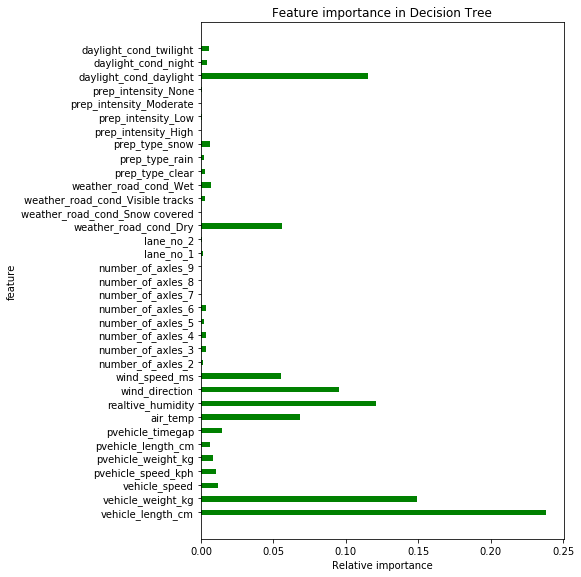

<Figure size 360x504 with 0 Axes>

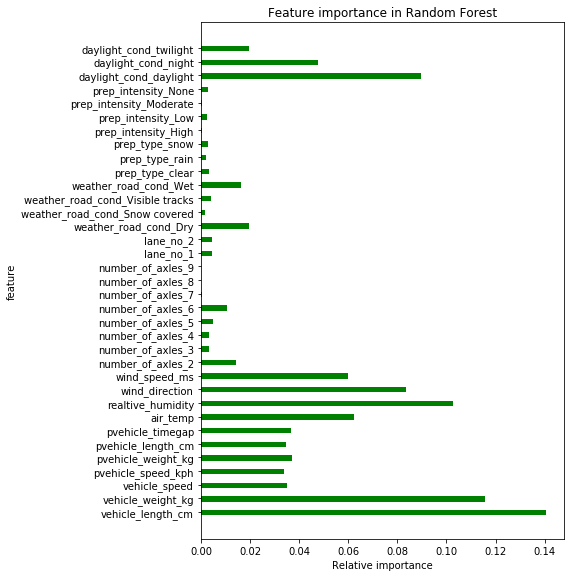

<Figure size 360x504 with 0 Axes>

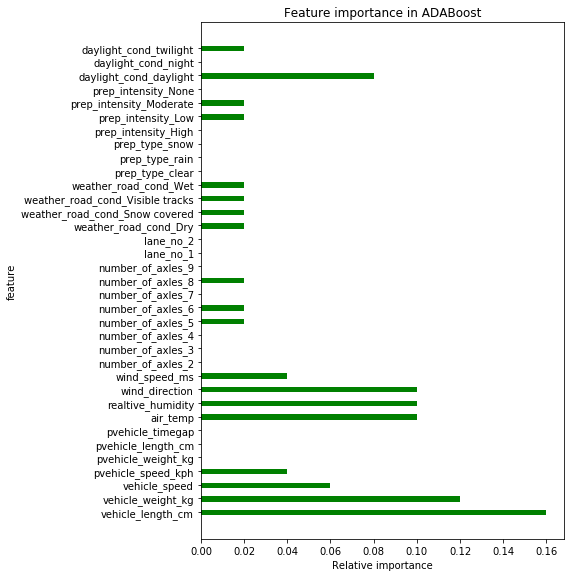

<Figure size 360x504 with 0 Axes>

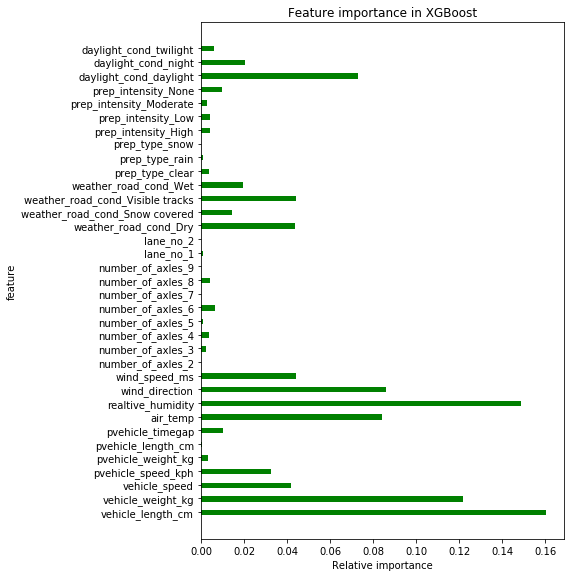

<Figure size 360x504 with 0 Axes>

In [682]:
decision_tree()
random_forest()
adaboost()
sgd()
xgboost()
catboost()
lightgbm()

In [670]:
train_split_X.columns

Index(['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed',
       'pvehicle_speed_kph', 'pvehicle_weight_kg', 'pvehicle_length_cm',
       'pvehicle_timegap', 'air_temp', 'realtive_humidity', 'wind_direction',
       'wind_speed_ms', 'number_of_axles_2', 'number_of_axles_3',
       'number_of_axles_4', 'number_of_axles_5', 'number_of_axles_6',
       'number_of_axles_7', 'number_of_axles_8', 'number_of_axles_9',
       'lane_no_1', 'lane_no_2', 'weather_road_cond_Dry',
       'weather_road_cond_Snow covered', 'weather_road_cond_Visible tracks',
       'weather_road_cond_Wet', 'prep_type_clear', 'prep_type_rain',
       'prep_type_snow', 'prep_intensity_High', 'prep_intensity_Low',
       'prep_intensity_Moderate', 'prep_intensity_None',
       'daylight_cond_daylight', 'daylight_cond_night',
       'daylight_cond_twilight'],
      dtype='object')

In [659]:
print(copy_data.shape)
print(train_split_Y.shape)

(103155, 35)
(61893,)


In [619]:
print(data[data['DrivingStyle']==1].shape)
print(data[data['DrivingStyle']==2].shape)
print(data[data['DrivingStyle']==3].shape)

(26074, 32)
(41075, 32)
(36006, 32)


In [620]:
data.shape

(103155, 32)

In [ ]:
# y_true = np.array([0, 1, 1, 0, 1])
# y_pred = np.array([1, 0, 1, 0, 1])
# y_act = np.empty(3,dtype=int)
# y_pre = np.empty(3,dtype=int)
# #keep 1's
# # y_true, y_pred = zip(*[[y_true[i], y_pred[i]] for i in range(len(y_true)) if y_true[i]=="1"])
# print("y_true:",y_true)
# print("y_pred:",y_pred)
# # y_true, y_pred = [[y_true[i], y_pred[i]] for i in range(len(y_true)) if y_true[i]==1]
# count=0
# for i in range(len(y_true)):
#     if y_true[i]==1:
#         y_act[count] = y_true[i]
#         y_pre[count] = y_pred[i]
#         count+=1
# print("y_act:",y_act)
# print("y_pre:",y_pre)

# out = precision_recall_fscore_support(y_true, y_pred, average='micro')
# print(recall_score(y_act, y_pre))

In [7]:
# out

(0.6, 0.6, 0.6, None)

## Test Dataset preprocessing

In [68]:
test_data = pd.read_csv('Test.csv',na_values=[" ",".","NA","?","-",""])
test_vehicle = pd.read_csv('Test_Vehicletravellingdata.csv',na_values=[" ",".","NA","?","-",""])
test_weather = pd.read_csv('Test_WeatherData.csv',na_values=[" ",".","NA","?","-",""])

#### Test_data preprocessing

In [69]:
# checking null values in train_data
print(test_data.shape)
test_data.isnull().sum()

(4880, 4)


ID    0
V2    0
V5    0
V6    0
dtype: int64

In [70]:
test_data.columns = ["ID","vehicle_length_cm","vehicle_weight_kg","number_of_axles"]

In [71]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880 entries, 0 to 4879
Data columns (total 4 columns):
ID                   4880 non-null object
vehicle_length_cm    4880 non-null int64
vehicle_weight_kg    4880 non-null int64
number_of_axles      4880 non-null int64
dtypes: int64(3), object(1)
memory usage: 152.6+ KB


#### Test Vehicle data

In [72]:
# checking null values in train_vehicle
print(test_vehicle.shape)
test_vehicle.isnull().sum()

(61671, 10)


ID       0
V1       0
V3       0
V4       0
V7       0
V8       0
V9       0
V10      0
V11    956
V18      0
dtype: int64

In [73]:
test_vehicle.columns = ["ID","trip_datetime","lane_no","vehicle_speed","pvehicle_id","pvehicle_speed_kph","pvehicle_weight_kg","pvehicle_length_cm","pvehicle_timegap","weather_road_cond"]

In [74]:
# checking null values in train_weather
print(test_vehicle.shape)
test_vehicle.isnull().sum()

(61671, 10)


ID                      0
trip_datetime           0
lane_no                 0
vehicle_speed           0
pvehicle_id             0
pvehicle_speed_kph      0
pvehicle_weight_kg      0
pvehicle_length_cm      0
pvehicle_timegap      956
weather_road_cond       0
dtype: int64

In [75]:
test_vehicle['pvehicle_timegap'] = test_vehicle['pvehicle_timegap'].fillna(data['pvehicle_timegap'].mean())

In [76]:
test_vehicle['pvehicle_timegap'] = test_vehicle['pvehicle_timegap'].astype('int64')

In [77]:
test_vehicle.isnull().sum()

ID                    0
trip_datetime         0
lane_no               0
vehicle_speed         0
pvehicle_id           0
pvehicle_speed_kph    0
pvehicle_weight_kg    0
pvehicle_length_cm    0
pvehicle_timegap      0
weather_road_cond     0
dtype: int64

In [78]:
test_vehicle['trip_datetime'] = test_vehicle['trip_datetime'].astype('datetime64')

#### Test Weather data

In [79]:
# checking null values in train_data
print(test_weather.shape)
test_weather.isnull().sum()

(61671, 9)


ID       0
V1       0
V12    934
V13      0
V14    973
V15    943
V16    964
V17    983
V19      0
dtype: int64

In [80]:
test_weather.columns = ["ID",'trip_datetime','air_temp','prep_type','prep_intensity','realtive_humidity','wind_direction','wind_speed_ms','daylight_cond']

In [81]:
test_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61671 entries, 0 to 61670
Data columns (total 9 columns):
ID                   61671 non-null object
trip_datetime        61671 non-null object
air_temp             60737 non-null float64
prep_type            61671 non-null object
prep_intensity       60698 non-null object
realtive_humidity    60728 non-null float64
wind_direction       60707 non-null float64
wind_speed_ms        60688 non-null float64
daylight_cond        61671 non-null object
dtypes: float64(4), object(5)
memory usage: 4.2+ MB


In [82]:
test_weather['air_temp'] = test_weather['air_temp'].fillna(math.ceil(data['air_temp'].mean()))  #ceil
test_weather['realtive_humidity'] = test_weather['realtive_humidity'].fillna(math.ceil(data['realtive_humidity'].mean()))
test_weather['wind_direction'] = test_weather['wind_direction'].fillna(180) #ceil
test_weather['wind_speed_ms'] = test_weather['wind_speed_ms'].fillna(math.floor(data['wind_speed_ms'].mean()))

In [83]:
test_weather['prep_intensity'] = test_weather['prep_intensity'].astype('category')

In [84]:
test_weather['prep_intensity'] = test_weather['prep_intensity'].fillna(data['prep_intensity'].mode()[0])

In [85]:
test_weather.isnull().sum()

ID                   0
trip_datetime        0
air_temp             0
prep_type            0
prep_intensity       0
realtive_humidity    0
wind_direction       0
wind_speed_ms        0
daylight_cond        0
dtype: int64

In [86]:
test_weather['trip_datetime'] = test_weather['trip_datetime'].astype('datetime64')

**Applying inner join on test datasets**

In [87]:
test = pd.merge(test_data,test_vehicle,on='ID',how='inner')
print(test.shape)
test = pd.merge(test,test_weather,on=['ID','trip_datetime'],how='inner')
print(test.shape)

(61671, 13)
(61671, 20)


In [88]:
test.isnull().sum()

ID                    0
vehicle_length_cm     0
vehicle_weight_kg     0
number_of_axles       0
trip_datetime         0
lane_no               0
vehicle_speed         0
pvehicle_id           0
pvehicle_speed_kph    0
pvehicle_weight_kg    0
pvehicle_length_cm    0
pvehicle_timegap      0
weather_road_cond     0
air_temp              0
prep_type             0
prep_intensity        0
realtive_humidity     0
wind_direction        0
wind_speed_ms         0
daylight_cond         0
dtype: int64

In [89]:
del test_data
del test_vehicle
del test_weather

In [90]:
for column in test.columns:
    if test[column].dtypes == 'object':
        test[column] = test[column].astype('category')

In [91]:
test.dtypes

ID                          category
vehicle_length_cm              int64
vehicle_weight_kg              int64
number_of_axles                int64
trip_datetime         datetime64[ns]
lane_no                        int64
vehicle_speed                  int64
pvehicle_id                    int64
pvehicle_speed_kph             int64
pvehicle_weight_kg             int64
pvehicle_length_cm             int64
pvehicle_timegap               int64
weather_road_cond           category
air_temp                     float64
prep_type                   category
prep_intensity              category
realtive_humidity            float64
wind_direction               float64
wind_speed_ms                float64
daylight_cond               category
dtype: object

In [92]:
test.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ID,61671,4880,DR_86793,99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vehicle_length_cm,61671,NaN,NaN,NaN,NaN,NaN,860.136,489.797,256,549,576,1039.5,2392
vehicle_weight_kg,61671,NaN,NaN,NaN,NaN,NaN,5954.41,7846.32,94,1632,2010,5064,45185
number_of_axles,61671,NaN,NaN,NaN,NaN,NaN,2.84374,1.46403,2,2,2,3,9
trip_datetime,61671,61668,2012-12-12 05:03:27,2,2012-03-21 10:30:27,2013-04-30 16:25:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lane_no,61671,NaN,NaN,NaN,NaN,NaN,1.50383,0.499989,1,1,2,2,2
vehicle_speed,61671,NaN,NaN,NaN,NaN,NaN,83.4105,9.30759,1,78,83,88,169
pvehicle_id,61671,NaN,NaN,NaN,NaN,NaN,458079,271055,26,146376,590071,691036,794379
pvehicle_speed_kph,61671,NaN,NaN,NaN,NaN,NaN,83.4238,9.32066,1,78,83,88,169
pvehicle_weight_kg,61671,NaN,NaN,NaN,NaN,NaN,5058.39,7487.26,8,1504,1867,2682,65063


In [93]:
test['trip_date'] = test['trip_datetime'].dt.date
test['trip_date_day'] = test['trip_datetime'].dt.day
test['trip_month'] = test['trip_datetime'].dt.month
test['trip_year'] = test['trip_datetime'].dt.year
test['trip_time'] = test['trip_datetime'].dt.time
test['trip_hour'] = test['trip_datetime'].dt.hour
test['trip_minute'] = test['trip_datetime'].dt.minute
test['trip_sec'] = test['trip_datetime'].dt.second

In [94]:
test['speed_difference'] = test['vehicle_speed'] - test['pvehicle_speed_kph']

In [95]:
test['distance'] = (test['pvehicle_speed_kph']/3.6)*test['pvehicle_timegap']

In [96]:
test['distance'] = test['distance'].astype('int64')

In [97]:
# calculating the bin size
bins = list(range(0,data['distance'].max()+10,18613))

In [98]:
labels = ['Low','Medium','High']
test['binned_distance'] = pd.cut(test['distance'], bins=bins, labels=labels)
test['binned_distance'].value_counts()

Low       60840
Medium      750
High         81
Name: binned_distance, dtype: int64

In [117]:
test['number_of_axles'] = test['number_of_axles'].astype('category')

In [128]:
test['lane_no'] = test['lane_no'].astype('category')

In [129]:
test.to_csv("consolidate_test.csv",sep=",",index=None)

In [312]:
test_copy = test.copy()

In [313]:
test_IDs = test.ID

In [314]:
test.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'trip_datetime', 'lane_no', 'vehicle_speed', 'pvehicle_id',
       'pvehicle_speed_kph', 'pvehicle_weight_kg', 'pvehicle_length_cm',
       'pvehicle_timegap', 'weather_road_cond', 'air_temp', 'prep_type',
       'prep_intensity', 'realtive_humidity', 'wind_direction',
       'wind_speed_ms', 'daylight_cond', 'trip_date', 'trip_date_day',
       'trip_month', 'trip_year', 'trip_time', 'trip_hour', 'trip_minute',
       'trip_sec', 'speed_difference', 'distance', 'binned_distance'],
      dtype='object')

In [315]:
test_copy.drop(dropping_columns,axis=1,inplace=True)

In [316]:
test_categorical_columns = ['number_of_axles','lane_no','weather_road_cond','prep_type','prep_intensity','daylight_cond']

In [317]:
test_dummified_df =pd.get_dummies(test_copy[test_categorical_columns])

In [318]:
test_copy.drop(test_categorical_columns,axis=1,inplace=True)

In [319]:
test_df_list  = [test_copy,test_dummified_df]
test_copy = pd.concat(test_df_list,axis='columns')

In [320]:
test_copy.columns

Index(['vehicle_length_cm', 'vehicle_weight_kg', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'air_temp',
       'realtive_humidity', 'wind_direction', 'wind_speed_ms',
       'number_of_axles_2', 'number_of_axles_3', 'number_of_axles_4',
       'number_of_axles_5', 'number_of_axles_6', 'number_of_axles_7',
       'number_of_axles_9', 'lane_no_1', 'lane_no_2', 'weather_road_cond_Dry',
       'weather_road_cond_Snow covered', 'weather_road_cond_Visible tracks',
       'weather_road_cond_Wet', 'prep_type_clear', 'prep_type_rain',
       'prep_type_snow', 'prep_intensity_High', 'prep_intensity_Low',
       'prep_intensity_Moderate', 'prep_intensity_None',
       'daylight_cond_daylight', 'daylight_cond_night',
       'daylight_cond_twilight'],
      dtype='object')

In [321]:
test_copy['number_of_axles_8'] = 0

In [322]:
test_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61671 entries, 0 to 61670
Data columns (total 36 columns):
vehicle_length_cm                   61671 non-null int64
vehicle_weight_kg                   61671 non-null int64
vehicle_speed                       61671 non-null int64
pvehicle_id                         61671 non-null int64
pvehicle_speed_kph                  61671 non-null int64
pvehicle_weight_kg                  61671 non-null int64
pvehicle_length_cm                  61671 non-null int64
pvehicle_timegap                    61671 non-null int64
air_temp                            61671 non-null float64
realtive_humidity                   61671 non-null float64
wind_direction                      61671 non-null float64
wind_speed_ms                       61671 non-null float64
number_of_axles_2                   61671 non-null uint8
number_of_axles_3                   61671 non-null uint8
number_of_axles_4                   61671 non-null uint8
number_of_axles_5           

In [283]:
# testpca_scaled = pca.transform(test_copy)

train_accuracy_dt:  100.0 percent
validation_accuracy_dt: 93.67percent
             precision    recall  f1-score   support

          1       0.92      0.92      0.92      7858
          2       0.95      0.95      0.95     25967
          3       0.92      0.92      0.92     14945

avg / total       0.94      0.94      0.94     48770



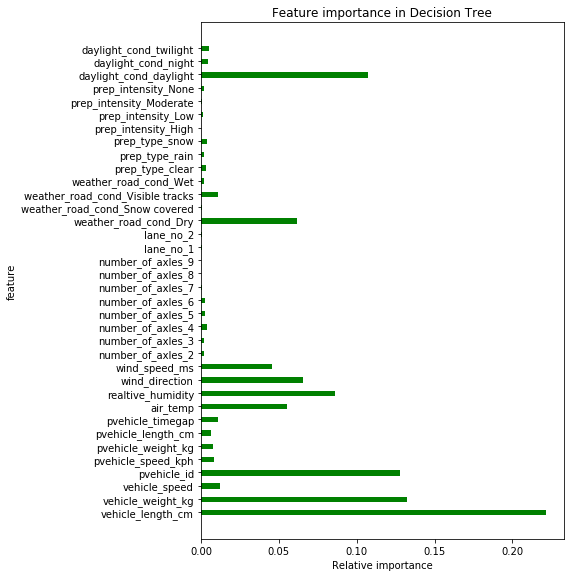

<Figure size 360x504 with 0 Axes>

In [323]:
clf = DecisionTreeClassifier(criterion='gini',class_weight='balanced')

#Using the object created for decision Trees to fit on train data
clf.fit(train_split_X, train_split_Y)

feat_importance(clf.feature_importances_,"Decision Tree")

#Using the object created for decision Trees to predict on validation data
y_pred_dt = clf.predict(val_split_X)
y_pred_dt_test = clf.predict(test_copy)

#Using the object created for decision Trees to predict on test data
#     test_y_pred_dt = clf.predict(test_data_cluster_4)

#Calculating the accuracy of train data
acc_dt_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
print ('train_accuracy_dt: ' +' '+str(acc_dt_train) + ' percent')

#Calculating the accuracy of validation data
acc_dt_validation = accuracy_score(val_split_Y, y_pred_dt)
print('validation_accuracy_dt: '+str(round((acc_dt_validation)*100,2)) + 'percent')
print(classification_report(val_split_Y, y_pred_dt))

------------------------------ Random Forest
train_accuracy_rf:  100.0 percent
validation_accuracy_rf: 96.7percent
             precision    recall  f1-score   support

          1       0.96      0.94      0.95      7858
          2       0.97      0.97      0.97     25967
          3       0.96      0.97      0.96     14945

avg / total       0.97      0.97      0.97     48770



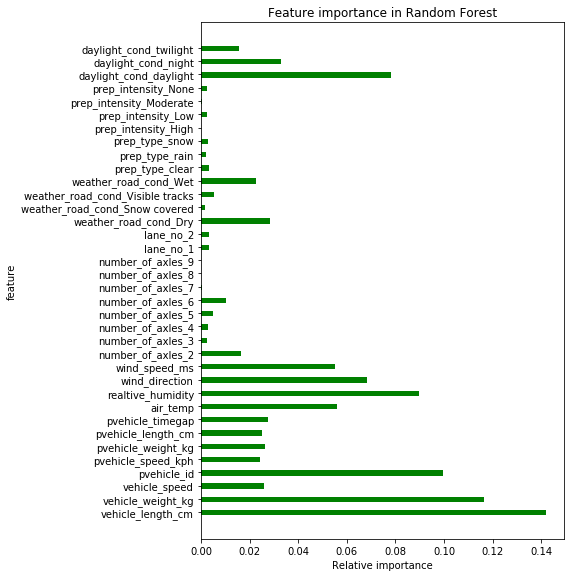

<Figure size 360x504 with 0 Axes>

In [359]:
print("-"*30,"Random Forest")
# Creating an object for Random Forest
# 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': False
clf = RandomForestClassifier(n_estimators= 1000, min_samples_split= 2,min_samples_leaf= 1, max_features= 'auto', max_depth= 50,bootstrap= False,n_jobs=-1,class_weight='balanced',)

#Using the object created for Random Forest to fit on train data
clf.fit(train_split_X, train_split_Y)

#checking the feature importance
feat_importance(clf.feature_importances_,"Random Forest")

#Using the object created for Random Forest to predict on validation data
y_pred_rf = clf.predict(val_split_X)
y_pred_rf_test = clf.predict(test_copy)

#Using the object created for Random Forest to predict on test data
#     test_y_pred_rf = clf.predict(test_data_cluster_4)

#Calculating the accuracy of train data
acc_rf_train = round( clf.score(train_split_X, train_split_Y) * 100, 2)
print ('train_accuracy_rf: ' +' '+str(acc_rf_train) + ' percent')

#Calculating the accuracy of validation data
acc_rf_validation = accuracy_score(val_split_Y, y_pred_rf)
print('validation_accuracy_rf: '+str(round((acc_rf_validation)*100,2)) + 'percent')
print(classification_report(val_split_Y, y_pred_rf))
#     rf_precision,rf_recall,rf_fscore,rf_support = precision_recall_fscore_support(val_split_Y, y_pred_rf, average='micro',labels=[1])
#     print("Recall: ",rf_recall)
#     print("Precision: ",rf_precision)

In [333]:
submission_df = pd.DataFrame(test_IDs,index=None)

In [334]:
submission_df['DrivingStyle'] = y_pred_rf_test

In [335]:
submission_df.head()

,ID,DrivingStyle
0,DR_79986,3
1,DR_79986,3
2,DR_79986,3
3,DR_79986,3
4,DR_79986,3


In [336]:
final_submission = submission_df.groupby(['ID'],sort=False).agg(lambda x:x.value_counts().index[0])

In [337]:
final_submission.head()

,DrivingStyle
ID,
DR_79986,3
DR_82800,2
DR_93526,2
DR_94423,2
DR_93909,2


In [338]:
final_submission.to_csv("final_submission_1.csv")

In [228]:
temp = submission_df.groupby(['ID','DrivingStyle']).size().to_frame()
# temp = temp.reset_index()
# temp.columns = ['DrivingStyle','weather_road_cond','Count']

In [247]:
submission_df.head(20)

,ID,DrivingStyle
0,DR_79986,3
1,DR_79986,3
2,DR_79986,3
3,DR_79986,3
4,DR_79986,3
5,DR_79986,3
6,DR_79986,3
7,DR_79986,3
8,DR_79986,3
9,DR_79986,3


In [684]:
data.columns

Index(['ID', 'vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles',
       'DrivingStyle', 'trip_datetime', 'lane_no', 'vehicle_speed',
       'pvehicle_id', 'pvehicle_speed_kph', 'pvehicle_weight_kg',
       'pvehicle_length_cm', 'pvehicle_timegap', 'weather_road_cond',
       'air_temp', 'prep_type', 'prep_intensity', 'realtive_humidity',
       'wind_direction', 'wind_speed_ms', 'daylight_cond', 'trip_date',
       'trip_date_day', 'trip_month', 'trip_year', 'trip_time', 'trip_hour',
       'trip_minute', 'trip_sec', 'speed_difference', 'distance',
       'binned_distance'],
      dtype='object')

In [689]:
from statistics import mean,mode

In [690]:
temp = data.groupby(['ID','DrivingStyle','vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles']).agg(mode('lane_no'),\
                                                    mean('vehicle_speed'),\
                                                    mode('weather_road_cond'),\
                                                    mean('air_temp'),\
                                                    mode('prep_type'),\
                                                    mode('prep_intensity'),\
                                                    mean('realtive_humidity',\
                                                    mean('wind_direction'),\
                                                    mean('wind_speed_ms'),\
                                                    mode('daylight_cond'))).size().to_frame()

TypeError: can't convert type 'str' to numerator/denominator

In [731]:
temp = data.groupby(['ID','vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles']) \
  .apply(lambda x: pd.DataFrame({
    'ID'               : x['ID'],
    'vehicle_length_cm': x['vehicle_length_cm'].mean(),
    'vehicle_weight_kg': x['vehicle_weight_kg'].mean(),
    'number_of_axles'  : x['number_of_axles'].mode(),
    'lane_no'          : x['lane_no'].mode(),
    'vehicle_speed'    : x['vehicle_speed'].mean(),
    'weather_road_cond': x['weather_road_cond'].mode(),
    'air_temp'         : x['air_temp'].mean(),
    'prep_type'        : x['prep_type'].mode(),
    'prep_intensity'   : x['prep_intensity'].mode(),
    'realtive_humidity': x['realtive_humidity'].mean(),
    'wind_direction'   : x['wind_direction'].mean(),
    'wind_speed_ms'    : x['wind_speed_ms'].mean(),
    'daylight_cond'    : x['daylight_cond'].mode(),
    'DrivingStyle'     : x['DrivingStyle'].mode()
  })
)

In [734]:
temp = data.groupby(['ID','vehicle_length_cm', 'vehicle_weight_kg', 'number_of_axles']) \
  .apply(lambda x: pd.DataFrame({
    'ID'               : x['ID'],
    'lane_no'          : x['lane_no'].mode(),
    'vehicle_speed'    : x['vehicle_speed'].mean(),
    'weather_road_cond': x['weather_road_cond'].mode(),
    'air_temp'         : x['air_temp'].mean(),
    'prep_type'        : x['prep_type'].mode(),
    'prep_intensity'   : x['prep_intensity'].mode(),
    'realtive_humidity': x['realtive_humidity'].mean(),
    'wind_direction'   : x['wind_direction'].mean(),
    'wind_speed_ms'    : x['wind_speed_ms'].mean(),
    'daylight_cond'    : x['daylight_cond'].mode(),
    'DrivingStyle'     : x['DrivingStyle'].mode()
  })
)

In [733]:
temp.head(20)

ID  \
ID       vehicle_length_cm vehicle_weight_kg number_of_axles                    
DR_10013 1709              18599             6               0            NaN   
                                                             93208   DR_10013   
                                                             93209   DR_10013   
                                                             93210   DR_10013   
                                                             93211   DR_10013   
                                                             93212   DR_10013   
                                                             93213   DR_10013   
                                                             93214   DR_10013   
                                                             93215   DR_10013   
                                                             93216   DR_10013   
DR_10024 1768              14588             5               0            NaN   
                                                             17429   DR_10024   
                                                             17430   DR_10024   
                                                             17431   DR_10024   
                                                             17432   DR_10024   
                                                             17433   DR_10024   
                                                             17434   DR_10024   
DR_10025 1734              16708             5               0            NaN   
                                                             102026  DR_10025   
                                                             102027  DR_10025   

                                                                     vehicle_length_cm  \
ID       vehicle_length_cm vehicle_weight_kg number_of_axles                             
DR_10013 1709              18599             6               0                  1709.0   
                                                             93208              1709.0   
                                                             93209              1709.0   
                                                             93210              1709.0   
                                                             93211              1709.0   
                                                             93212              1709.0   
                                                             93213              1709.0   
                                                             93214              1709.0   
                                                             93215              1709.0   
                                                             93216              1709.0   
DR_10024 1768              14588             5               0                  1768.0   
                                                             17429              1768.0   
                                                             17430              1768.0   
                                                             17431              1768.0   
                                                             17432              1768.0   
                                                             17433              1768.0   
                                                             17434              1768.0   
DR_10025 1734              16708             5               0                  1734.0   
                                                             102026             1734.0   
                                                             102027             1734.0   

                                                                     vehicle_weight_kg  \
ID       vehicle_length_cm vehicle_weight_kg number_of_axles                             
DR_10013 1709              18599             6               0                 18599.0   
                                         

In [727]:
temp.isnull().sum()

ID                     9408
vehicle_length_cm      9408
vehicle_weight_kg      9408
number_of_axles        9408
lane_no              103155
vehicle_speed             0
weather_road_cond    104236
air_temp                  0
prep_type            104241
prep_intensity       104241
realtive_humidity         0
wind_direction            0
wind_speed_ms             0
daylight_cond        104241
dtype: int64

In [728]:
temp.shape

(112563, 14)

In [723]:
temp.shape

(9410, 10)

In [724]:
temp.to_csv("temp.csv",index=None)

In [714]:
temp['DrivingStyle'].value_counts()

3    2774
2    2774
1    2774
Name: DrivingStyle, dtype: int64